# Classifiez automatiquement des biens de consommation

## Résumé du projet
"Place de marché”, qui souhaite lancer une marketplace e-commerce. Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description

L'objectif principal de ce projet est d'etudier la faisabilité d'un moteur de classification des articles en différentes catégories des dponnees de l'entreprise Place de marché.

Cela permetra de  rendre l’expérience utilisateur des vendeurs et des acheteurs  la plus fluide possible. En plus, dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche 


## Chargement des bibliothèques nécessaires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import seaborn as sns
import os
import shutil
import re
from zipfile import ZipFile
from os import listdir
from pathlib import Path
from functools import reduce
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,plot_confusion_matrix

import sklearn.metrics as metrics
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import intercluster_distance
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, accuracy_score


from sklearn.manifold import TSNE

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
from sklearn import decomposition, preprocessing
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

stemmer    = EnglishStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import PCA

import cv2

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix

pd.set_option("display.precision", 2)          
pd.set_option("display.max.columns", None)    
pd.set_option("display.max.rows", None)

import warnings
warnings.simplefilter(action='ignore', category=Warning)

[nltk_data] Downloading package stopwords to /home/yonss/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yonss/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yonss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Extraction  des données

In [2]:
dir_data = Path('../../DATA/P6') 
dir_fig  = Path('../../FIGURE/P6')
work_dir=os.getcwd()
CHECK_FOLDER  = Path('../../DATA/P6/Flipkart') 

if CHECK_FOLDER.exists():
    print ("Fichier existe") 
else:
    for dirname, _, filenames in os.walk(dir_data):
        for filename in filenames:
            file_in=os.path.join(dirname, filename)
            print(file_in)
            with ZipFile(file_in, 'r') as zip:
                zip.extractall(dir_data)
#
print(os.listdir(CHECK_FOLDER))

Fichier existe
['Images', 'flipkart_com-ecommerce_sample_1050.csv']


Le dataset est constitue d'un fichier en format .csv et des images en format .jpg (Les images sont dans le dossier Images).
On va d'abord analyser les information contenue dans le fichier .csv

# Classification d'articles basé sur la description des articles

## Description des données contenue dans le fichier .csv

In [3]:
list_files = [file for file in listdir(CHECK_FOLDER)]
files=[]
for f in os.listdir(CHECK_FOLDER):
    if f.endswith('.csv'):
        files.append(os.path.join(CHECK_FOLDER,f))
        if len(files)==1:
            df =pd.read_csv(files[0])
        else:
            print('ATT: Regarde les donnees')

In [4]:
df.shape

(1050, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
df_null = df.isnull().sum()
df_null

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [7]:
toplop=df_null
colplot=['Variables','Valeur Manquantes']
dss=22

import plotly.graph_objects as go
plt.rc('font', size=15)
fig = go.Figure(data=[go.Table(
    columnwidth = [10,10],
    header=dict(values=list(colplot),
                fill_color='paleturquoise',
                align='left',
                height=dss),
    cells=dict(values=[df_null.index, toplop],
               fill_color='lavender',
               align='left',
               height=dss))
])
fig.update_layout(height=370,width=280,margin=dict(t=0,b=0,l=0,r=0))
fig.show()

figure_name='val_manq.jpeg'
fig.write_image(figure_name)


!cp val_manq.jpeg  /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv val_manq.jpeg   /home/yonss/Data_Scientist/FIGURE/P6

La majeure partie des variables sont catégorielles. Deux variables uniquement sont des numériques.

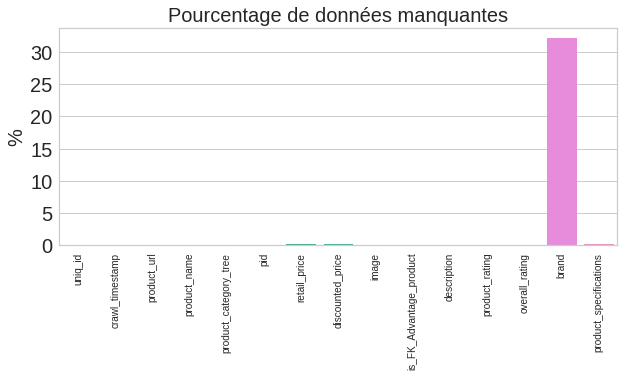

In [8]:
# Calcul du nombre de valeurs manquantes par colonne
df_na = df.isna().sum()/len(df)*100
# Affichage graphique
fig = plt.figure(1, figsize=(10, 4))
sns.barplot(x=df_na.index, y=df_na.values)
plt.xticks(rotation=90)
plt.xlabel("",fontsize=20)
plt.ylabel("%",fontsize=20)
plt.title("Pourcentage de données manquantes",fontsize=20)
plt.rc('font', size=20 ) 
plt.yticks(fontsize=20) 
figure_name='data_manq.jpeg'

plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp data_manq.jpeg /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv data_manq.jpeg  /home/yonss/Data_Scientist/FIGURE/P6

In [9]:
define_max_acepteble_nan= 4     # 4 c'est 1/4 de NaN or Nul
print(len(df)/define_max_acepteble_nan)
for col_name in df.columns:
    if df_null[col_name]>0:
        if df_null[col_name]>len(df)/define_max_acepteble_nan:
            print(col_name,df_null[col_name])
            df=df.drop([col_name], axis=1)
        else:
            if df[col_name].dtypes==np.float64:
                df[col_name].fillna(value = df[col_name].mean(), inplace=True)
                print(col_name, df_null[col_name])
            else:
                df[col_name].fillna(value = 'Unknown', inplace=True)
                print(col_name, df_null[col_name])
        #


262.5
retail_price 1
discounted_price 1
brand 338
product_specifications 1


In [10]:
df['product_category_tree'].head()

0    ["Home Furnishing >> Curtains & Accessories >>...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
Name: product_category_tree, dtype: object

In [11]:
def split_cat_var(column):
    categorie = column.split('["')[1].split('"]')[0]
    cat = categorie.split(' >> ')[knx]
    return cat

for knx in range(0,1):
    name=str('Categories_text')
    print(name)
    df[name] = df['product_category_tree'].apply(split_cat_var)

Categories_text


In [12]:
print(df[name].unique())

['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


In [13]:
df[name] = df[name].str.replace(
    '&', 'and')
df[name] = df[name].str.replace(
    ' ', '_')
df[name] = df[name].str.lower()

In [14]:
print(df[name].nunique())

7


In [15]:
lab_category = {'home_furnishing':0, 'baby_care':1,'watches':2,'home_decor_and_festive_needs':3,\
                'kitchen_and_dining':4,'beauty_and_personal_care':5,'computers':6}
def label_decoder(label):
    return lab_category[label]
name2='L_Categories_text'
df[name2] =df[name].apply(lambda x: label_decoder(x))


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1050 non-null   float64
 7   discounted_price         1050 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  product_specifications   1050 non-null   object 
 14  Categories_text         

In [17]:
df[name].value_counts()

home_furnishing                 150
baby_care                       150
watches                         150
home_decor_and_festive_needs    150
kitchen_and_dining              150
beauty_and_personal_care        150
computers                       150
Name: Categories_text, dtype: int64

<Figure size 2160x1080 with 0 Axes>

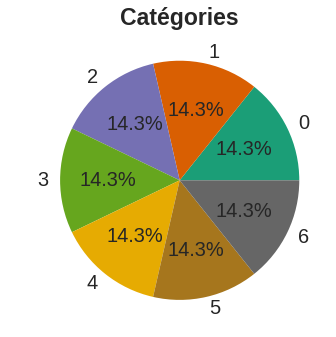

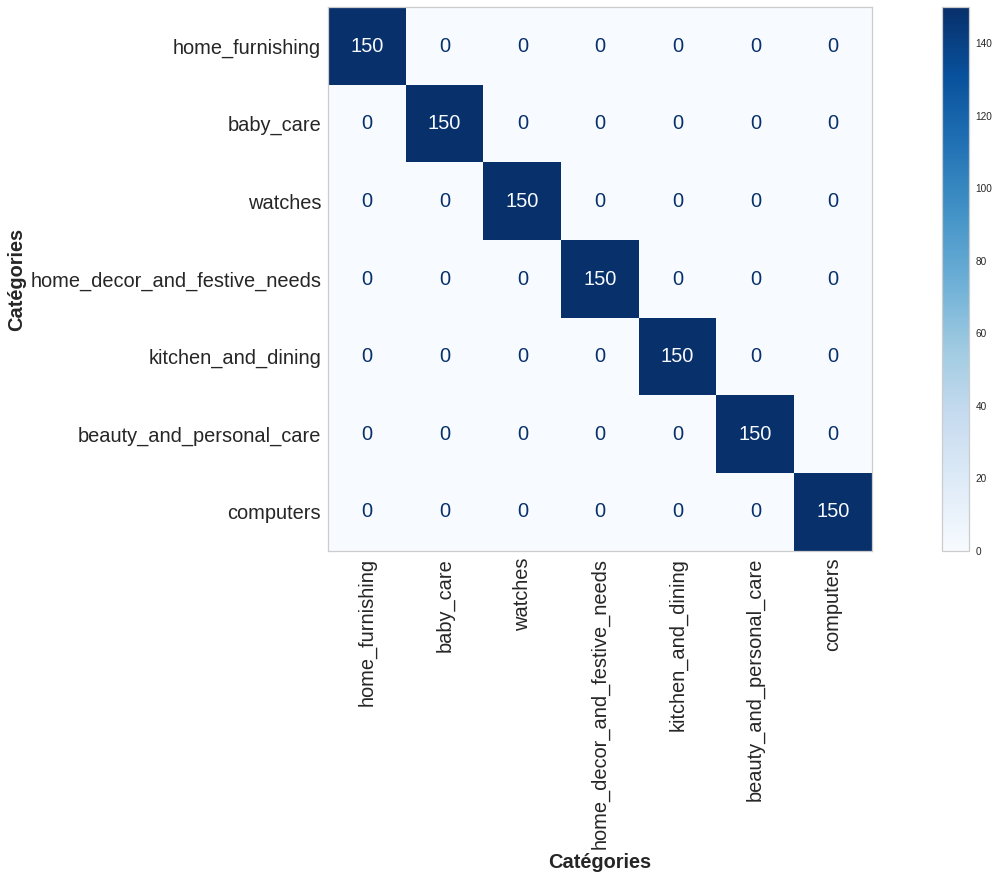

In [18]:
data_plot_0 = df.groupby(name2).agg(Categories =('uniq_id','count'))
data_plot_0=data_plot_0.sort_values(by='Categories', ascending=False)
cmo = confusion_matrix(df[name], df[name])
dss=20
fig = plt.figure(1, figsize=(30, 15))
data_plot_0.plot(kind='pie', x=name, y='Categories', title = '', 
cmap='Dark2', autopct="%.1f%%", legend=False,fontsize=dss);
plt.title("Catégories", weight='bold', size=dss+3)

plt.xlabel("",fontsize=dss)
plt.ylabel(" ",fontsize=dss)

plt.xticks(fontsize=dss)
plt.grid(False)

plt.rc('font', size=dss ) 
plt.yticks(fontsize=dss) 
figure_name='data_avail.jpeg'

plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp data_avail.jpeg /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv data_avail.jpeg  /home/yonss/Data_Scientist/FIGURE/P6
#----------------------------------------------------------------------
#f.subplots_adjust(left=0.1,bottom=0.1, right=1.1, top=0.9, wspace=0.4, hspace=0.4)
fig, ax2 = plt.subplots(figsize=(25,10))

cm_display = ConfusionMatrixDisplay(cmo).plot(ax=ax2,cmap=plt.cm.Blues)
plt.rcParams.update({'font.size': dss})
ax2.set_ylabel("Catégories", weight='bold', size=dss)
ax2.set_xlabel('Catégories', weight='bold', size=dss)
ax2.set_yticklabels(df[name].unique(), size=dss)
ax2.set_xticklabels(df[name].unique(), size=dss)
plt.xticks(fontsize=dss)
plt.xticks(rotation=90)
plt.grid(False)

plt.rc('font', size=dss ) 
plt.yticks(fontsize=dss) 
figure_name='data_avail2.jpeg'

plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp data_avail2.jpeg /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv data_avail2.jpeg  /home/yonss/Data_Scientist/FIGURE/P6


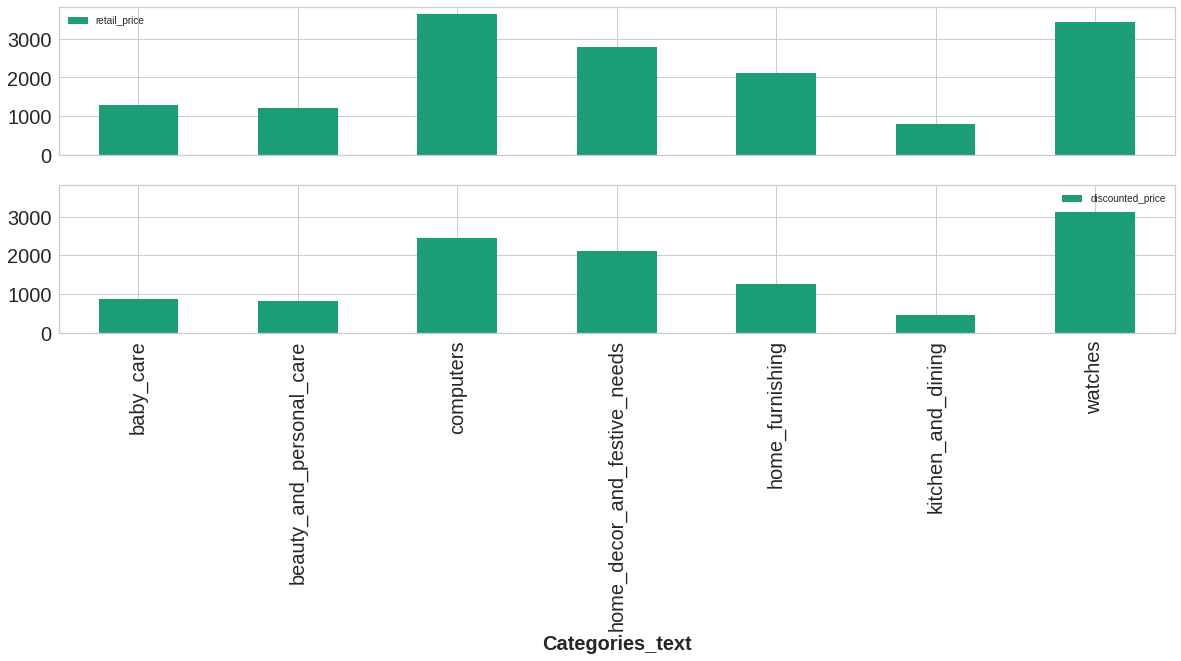

In [19]:
data_plot_1  = df.groupby(name).agg(retail_price =('retail_price','mean'))
data_plot_10 = df.groupby(name).agg(discounted_price =('discounted_price','mean'))
dss=20
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,6),sharex=True,sharey=True)

data_plot_1.plot(kind='bar', title = '', cmap='Dark2',ax=ax1, rot = 90,fontsize=dss);
data_plot_10.plot(kind='bar', title = '', cmap='Dark2',ax=ax2, rot = 90,fontsize=dss);

plt.rc('font', size=dss ) 

plt.xlabel(name, weight='bold', size=dss)
plt.rc('font', size=dss ) 

figure_name='price.jpeg'

plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp price.jpeg /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv price.jpeg  /home/yonss/Data_Scientist/FIGURE/P6

In [20]:
file=str(dir_data) + '/df_clean.csv'
df.to_csv(file)

### Prétraitement des description des articles

In [21]:
#
tokens_var='description'
new_tokens_var='description_trans'

# 1 - lower case
df[tokens_var]= df[tokens_var].str.lower()

# 2 - tokenizing the words in each description
tokenizer = nltk.RegexpTokenizer(r'[A-Za-z]+')  #r'[a-z]{4,}')  #r'[a-z]+')  
df[new_tokens_var] = df[tokens_var].map(
        tokenizer.tokenize)


In [22]:
# 3 - lemmatizing 
df[new_tokens_var+str('lemm')] = df[new_tokens_var].apply(lambda x: [lemmatizer.lemmatize(s) for s in x])

#### Supprimer les stopwords

In [23]:
# 4: Suppression StopWord
sw_default  = stopwords.words('english')   # on récupère les stopword de nltk
sw_default = [l.lower() for l in list(sw_default)]

alphabet_string = list(string.ascii_lowercase)    #on récupère les lettres isolées

stopwordss = list(set(STOPWORDS))
stopwordss = [l.lower() for l in list(stopwordss)]

# trouver les 100 mots que l'on retrouve le plus dans toutes les descriptions
most=100
    
words_lemm = []
for wordList_lemm in df[new_tokens_var+str('lemm')]:
    words_lemm += wordList_lemm
    
mlist_l = nltk.FreqDist(words_lemm)
mostcommon = mlist_l.most_common(most) 
    
sw = set(sw_default + alphabet_string + mostcommon)


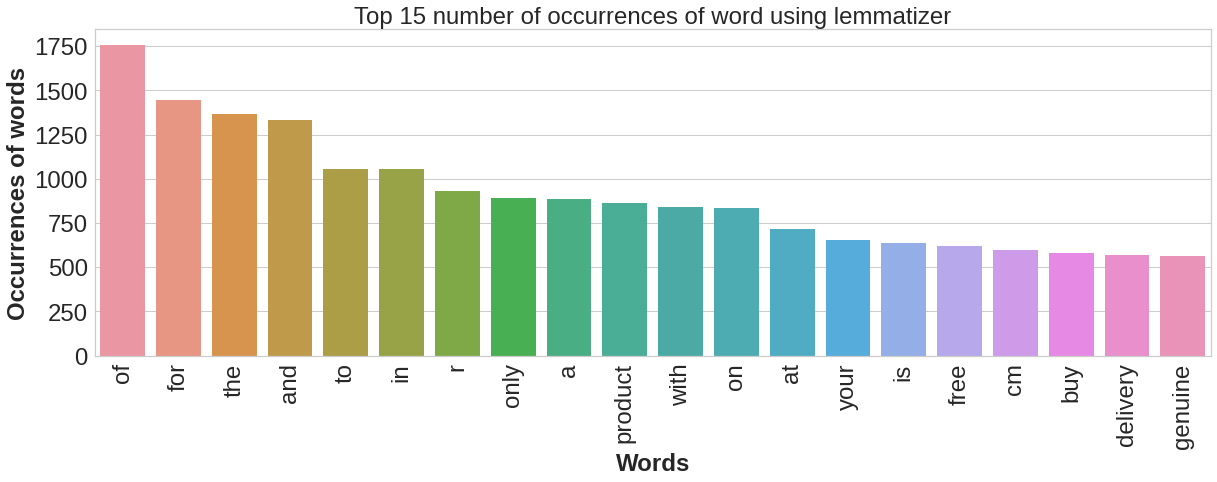

In [24]:
df_mc = pd.DataFrame(mostcommon)
dss=24

fig, ax2 = plt.subplots(figsize=(20,6))
sns.barplot(x=df_mc[0].head(20), y=df_mc[1].head(20),ax=ax2)
ax2.set_title("Top 15 number of occurrences of word using lemmatizer", size=dss)

ax2.set_ylabel( 'Occurrences of words',weight='bold', size=dss)
ax2.set_xlabel( 'Words', weight='bold', size=dss)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss)
plt.xticks(rotation=90)


plt.savefig('lemmatizer_word.jpeg',format='jpeg',dpi=100,bbox_inches='tight')
!cp "lemmatizer_word.jpeg" /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv "lemmatizer_word.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6


In [25]:

df[new_tokens_var+str('lemm')] = df[new_tokens_var+str('lemm')].apply(lambda x: [s for s in x if s not in sw])

In [26]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [27]:
no_features=10000
no_topics = 5
no_top_words = 10
max_df=0.95
min_df=0.05
rstate=10

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_df=max_df,  min_df=min_df, stop_words=sw)
tfidf = tfidf_vectorizer.fit_transform(df[new_tokens_var+str('lemm')].apply(lambda x: " ".join(x))).toarray()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
TfidfVec=pd.DataFrame(tfidf,columns=tfidf_feature_names)


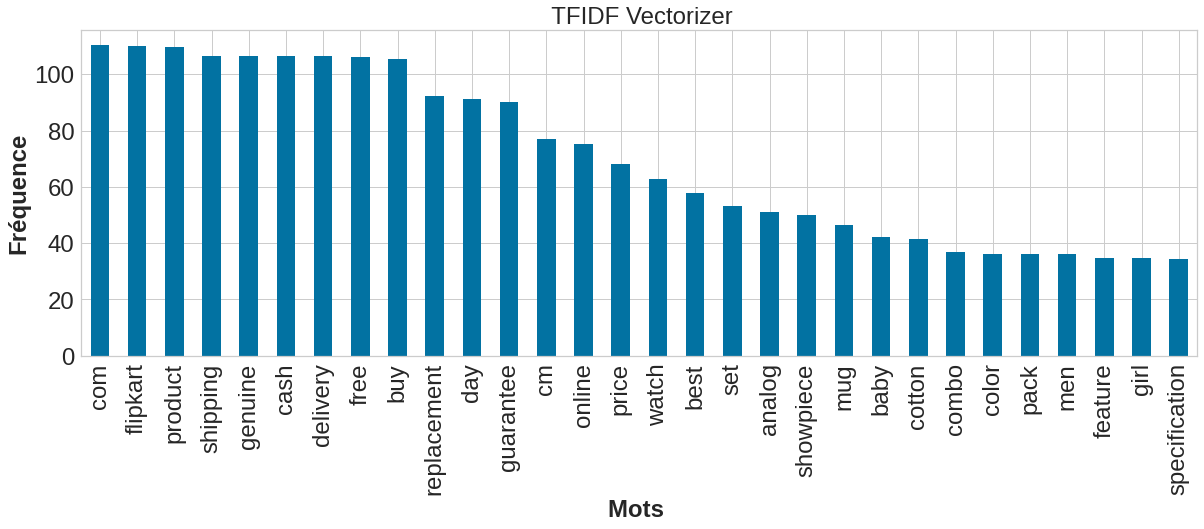

In [29]:
fig, ax2 = plt.subplots(figsize=(20,6))
TfidfVec.sum().sort_values(ascending=False).head(30).plot.bar(ax=ax2)

ax2.set_title(" TFIDF Vectorizer", size=dss)
ax2.set_ylabel('Fréquence', weight='bold', size=dss)
ax2.set_xlabel('Mots ', weight='bold', size=dss)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss)

plt.savefig('TFIDF_vect.jpeg',format='jpeg',dpi=100,bbox_inches='tight')
!cp "TFIDF_vect.jpeg" /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv "TFIDF_vect.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6


In [30]:
scaler = preprocessing.StandardScaler()

TfidfVec = scaler.fit_transform(TfidfVec)
TfidfVec = pd.DataFrame(data=TfidfVec)

In [31]:
dss=22
def display_scree_plot(pca,pc_list,ax,num_pc):
    scree = pca.explained_variance_ratio_*100
    ax.bar(pc_list, scree, alpha=0.5, align='center', label='individual explained variance')
    ax.step(pc_list,  scree.cumsum(),c="red",marker='o',where= 'mid', label='cumulative explained variance')
    plt.xticks(rotation =90) 
    ax.set_xticks(range(0,num_pc,5))
    ax.set_xticklabels( range(0,num_pc,5),size=dss-2)
    ax.set_xlabel("PCs",size=dss-2)
    ax.set_ylabel("Ratio de la variance expliqué",size=dss-2)
    ax.legend(loc = 'best')
    plt.xticks(fontsize=dss-2)
    plt.yticks(fontsize=dss-2)

In [32]:

def pca_dim_reduction(df,var_explaned,figure_name,figure_name1 ):
    pcamodel=decomposition.PCA(var_explaned)
    pcamodel.fit(df)
    explained_var=pcamodel.explained_variance_ratio_
    explained=pcamodel.explained_variance_ratio_.cumsum()
    loadings = pcamodel.components_
    num_pc = len(pcamodel.components_) 
    pc_list = [str(i) for i in list(range(1, num_pc+1))]  
#
    
    df_dim_red=pcamodel.transform(df)
    df_dim_red = pd.DataFrame(data=df_dim_red, columns=pc_list)

    fig, ax = plt.subplots(figsize=(25,8))
 
    display_scree_plot(pcamodel,pc_list,ax,num_pc)
    
    plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')
    plt.savefig(figure_name1,format='jpeg',dpi=100,bbox_inches='tight')
    
    return df_dim_red,pcamodel

[0.96453893 0.96727908 0.96986325 0.97232563 0.97463786 0.97693217
 0.97907021 0.98109164 0.98310022 0.98486508 0.98651633 0.98811718
 0.98958733 0.99097866 0.9922259  0.99343247 0.99445179 0.99544633
 0.99629388 0.99707143 0.99774641 0.99836389 0.99880755 0.99923515
 0.99957444 0.9998005  0.99992453 0.99997975 0.99999797 1.
 1.         1.        ]


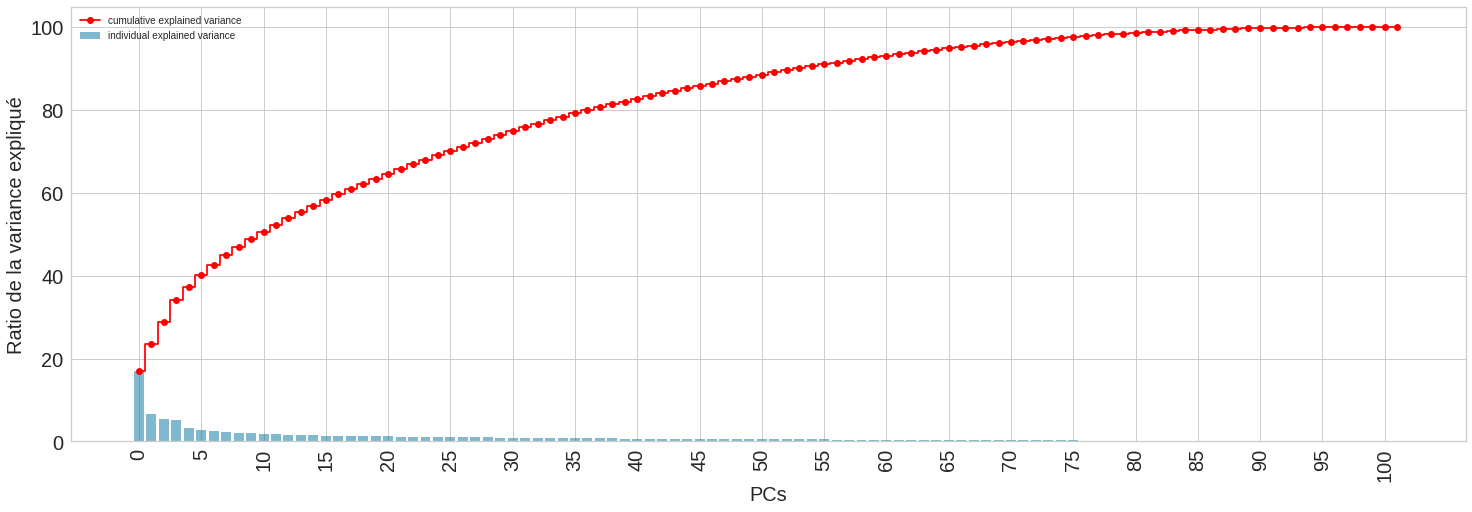

In [33]:
figure_name =Path(str(dir_fig) +'/' + str('PCA_texte.jpeg'))
figure_name1 =Path(str("/home/yonss/AndroidStudioProjects/P6_Presentation/Images") +'/' + str('PCA_texte.jpeg'))
var_explaned=TfidfVec.shape[1]
[cv_X_pca,pcamodel] = pca_dim_reduction(TfidfVec,var_explaned,figure_name,figure_name1) 

print(np.cumsum(pcamodel.explained_variance_ratio_)[70:])

Vous peut voir que les 70 premières composantes principales conservent plus de 95 % de la variabilité de l'ensemble de données.
Les 37 caractéristiques restantes ne contiennent que moins de 5% de la variabilité des données.

In [34]:
def pca_red_dim(model_res,var_explained):
    pca = PCA(var_explained)  
    df_PCA = pca.fit_transform(model_res)
    num_pc = len(pca.components_) 
    pc_list = [str(i) for i in list(range(1, num_pc+1))] 
    X_pca   = pca.transform(model_res)
    return pc_list,pca,X_pca

In [35]:
var_explained=70
[tfidf_pc,tfidf_pca,tfidf_X_pca] = pca_red_dim(TfidfVec,var_explained)
print('TfidfVec ---->  Taille avant  PCA',TfidfVec.shape,'---- Taille après  PCA',tfidf_X_pca.shape)

TfidfVec ---->  Taille avant  PCA (1050, 102) ---- Taille après  PCA (1050, 70)


In [36]:
df_tfidf = pd.DataFrame(tfidf_X_pca)

In [37]:
def fig_pca(X_PCA,df,ax,name):
    chaine = "Plan factoriel pour les composantes 1 et 2 de l'ACP"
    ax.set_title(chaine)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    sns.scatterplot(
        x=X_PCA[:,0],
        y=X_PCA[:,1],
        hue=df[name],ax=ax,
        alpha=0.8,
        s=30
    )

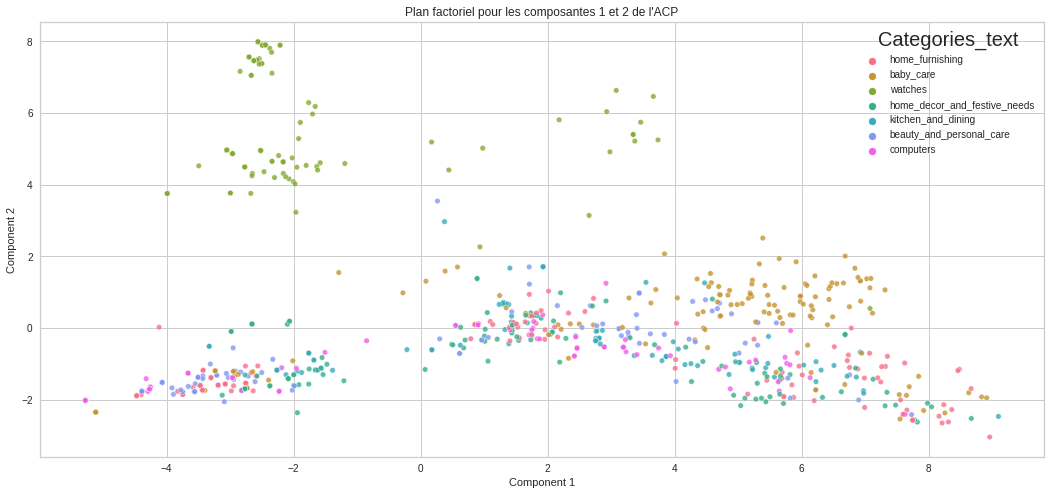

In [38]:
f, ax2 = plt.subplots(1,1, figsize=(18,8))
fig_pca(tfidf_X_pca,df,ax2,name)

In [39]:
tsne = TSNE(n_components=2, init="pca")
X_tsne_tfidf  = tsne.fit_transform(tfidf_X_pca)

df_tsne_tfidf = pd.DataFrame(X_tsne_tfidf[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_tfidf[name2] = df[name]
print(df_tsne_tfidf.shape)

(1050, 3)


In [40]:
def plot_tsne(df,ax,name,figure_name):
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=name, data=df, ax=ax,legend="brief",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,size=dss-2)

    ax.set_title('TSNE selon les vraies classes', fontweight = 'bold',size=dss-2)
    ax.set_xlabel('tsne1',size=dss-2)
    ax.set_ylabel('tsne2',size=dss-2)
    plt.xticks(fontsize=dss-2)
    plt.yticks(fontsize=dss-2)
    
    plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

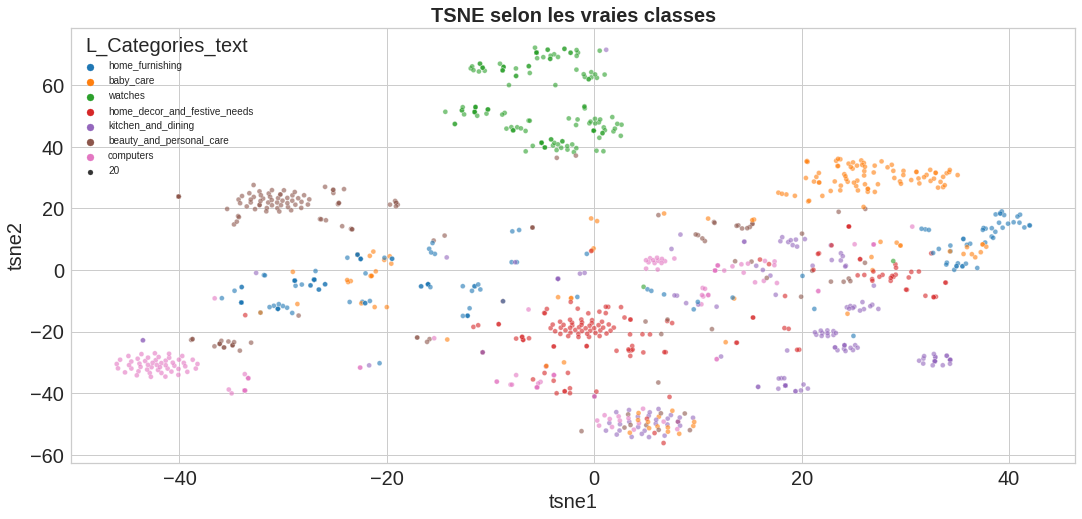

In [41]:
f, (ax1) = plt.subplots(1,1, figsize=(18,8))
plot_tsne(df_tsne_tfidf,ax1,name2,"tsne_2D.jpeg")
!mv "tsne_2D.jpeg" /home/yonss/AndroidStudioProjects/P6_Presentation/Images

In [42]:
X=df_tsne_tfidf
X[name]=df[name]
Y=df[name2]

In [43]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

Cat_train=x_train[name]
Cat_test =x_test[name]

x_train=x_train.drop([name,name2],axis=1)
x_test=x_test.drop([name,name2],axis=1)

# Application de la répartition des points de données en k groupes différents (k-means clustering)

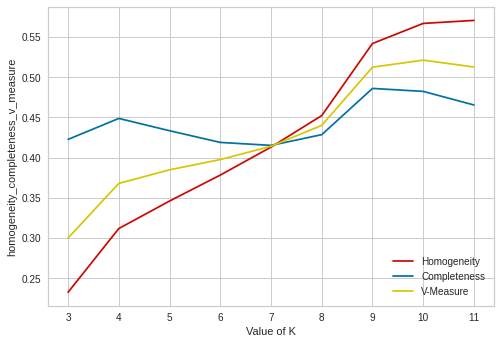

In [44]:
k = range(3,12)
scores = []
 
for n_cluster in k:
    y_pred = KMeans(n_clusters = n_cluster, max_iter=1000, random_state=42).fit_predict(x_train)
    score = metrics.homogeneity_completeness_v_measure(y_train, y_pred)
    scores.append(score)
            
# plotting the scores against the value of k
plt.plot(k, [s[0] for s in scores], 'r', label='Homogeneity')
plt.plot(k, [s[1] for s in scores], 'b', label='Completeness')
plt.plot(k, [s[2] for s in scores], 'y', label='V-Measure')
plt.xlabel('Value of K')
plt.ylabel('homogeneity_completeness_v_measure')
plt.legend(loc=4)
plt.show()

In [45]:
nclusters_cv=7

In [46]:
def stability_measure(nclusters,df):
    inx=0
    inx0=0
    inj=0
    df_stability=pd.DataFrame()
    #
    for knx in range(0,nclusters*3): 
        knx=nclusters
        kmeans_visualizer = KMeans(n_clusters=knx,init='random')
        kmeans_visualizer.fit(df)
        name1='Iteration  '+str(inj)
        df_stability[name1]=kmeans_visualizer.predict(df)
    
        inj0=inj-1
        if inj==0:
            name0=name1
            inj0=inj
        ARI_RFM_KMeans=adjusted_rand_score(df_stability[name1],df_stability[name0])
        print('ARI  '+ str(name1) + ' - ' + str(name0)+'     =  ' , ARI_RFM_KMeans ) 
        name0=name1
        inj=inj+1  
    return df_stability

x_stability = stability_measure(nclusters_cv,x_train)

ARI  Iteration  0 - Iteration  0     =   1.0
ARI  Iteration  1 - Iteration  0     =   0.7501717239247986
ARI  Iteration  2 - Iteration  1     =   0.7906582502966597
ARI  Iteration  3 - Iteration  2     =   0.7856403306217068
ARI  Iteration  4 - Iteration  3     =   0.7887478850405821
ARI  Iteration  5 - Iteration  4     =   0.9755732573662511
ARI  Iteration  6 - Iteration  5     =   0.9934158772926158
ARI  Iteration  7 - Iteration  6     =   0.9934158772926158
ARI  Iteration  8 - Iteration  7     =   0.7439841878836088
ARI  Iteration  9 - Iteration  8     =   0.7439841878836088
ARI  Iteration  10 - Iteration  9     =   0.9152087707654293
ARI  Iteration  11 - Iteration  10     =   0.9211527749681002
ARI  Iteration  12 - Iteration  11     =   0.9211527749681002
ARI  Iteration  13 - Iteration  12     =   0.8978829766603875
ARI  Iteration  14 - Iteration  13     =   0.9900677354373294
ARI  Iteration  15 - Iteration  14     =   0.8887616799426277
ARI  Iteration  16 - Iteration  15     =   1

In [47]:
def final_KMeans_model(X,X_test,nclusters,nstate):
    kmeans_visualizer = KMeans(n_clusters=nclusters,random_state=nstate)
    kmeans_visualizer.fit(X)
    name='Cluster = '+str(nclusters)
    X[name]=kmeans_visualizer.labels_
    # prédire les clusters sur l'ensemble de test
    X_test[name] = kmeans_visualizer.predict(X_test)
    return X,X_test,name ,kmeans_visualizer


[x_train,x_test,namecluster,kmeans_visualizer] = final_KMeans_model(x_train,x_test,nclusters_cv,rstate)

In [48]:
x_train[name]=Cat_train
x_test[name]=Cat_test

x_train[name2]=y_train
x_test[name2]=y_test

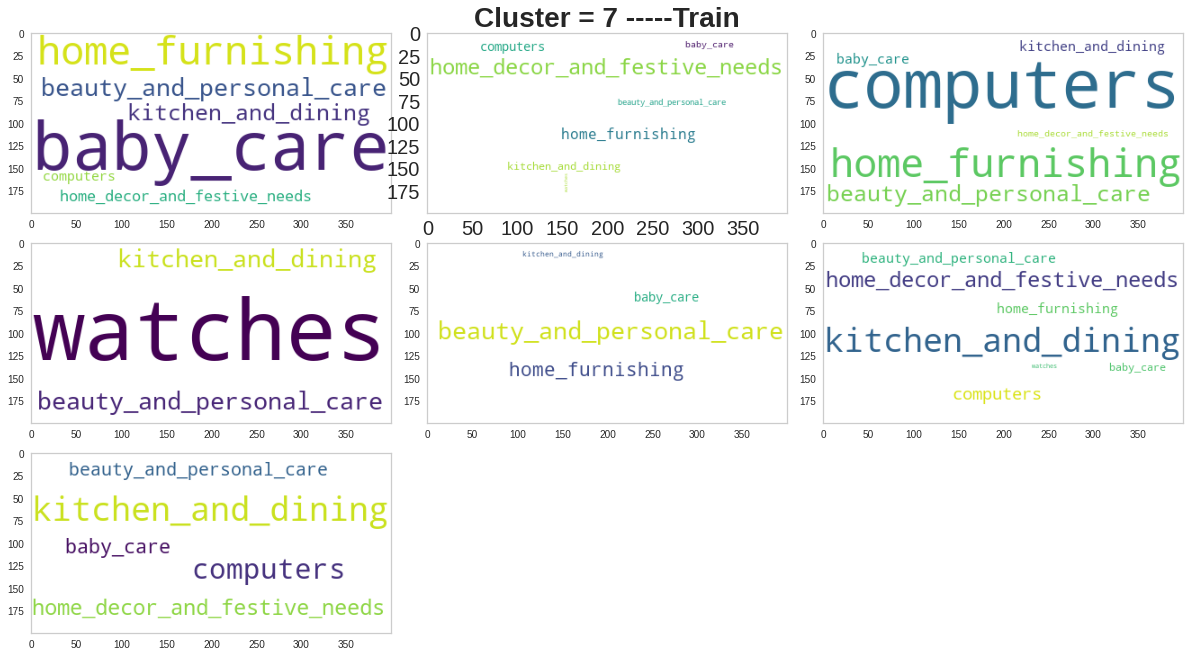

In [49]:
fig = plt.figure(figsize=(20,20))
for i in range(0,len(x_train[namecluster].unique())):
    lab1=x_train[x_train[namecluster]==i]
    wordstring=" ".join(lab1[name])
    ax = fig.add_subplot(3,3,i+1)
    wrdcloud=WordCloud(background_color='white',
                      max_font_size = 100,
                      collocations=False).generate(wordstring)
    ax.imshow(wrdcloud)
    ax.axis('on')
    ax.grid(False)
    if i==1:
        ax.set_title(namecluster +' -----Train', weight='bold', size=dss+6)
                
        plt.xticks(fontsize=dss-2)
        plt.yticks(fontsize=dss-2)

fig.subplots_adjust(left=0.1,bottom=.6, right=0.9, top=1.1, wspace=0.1, hspace=-0.3)

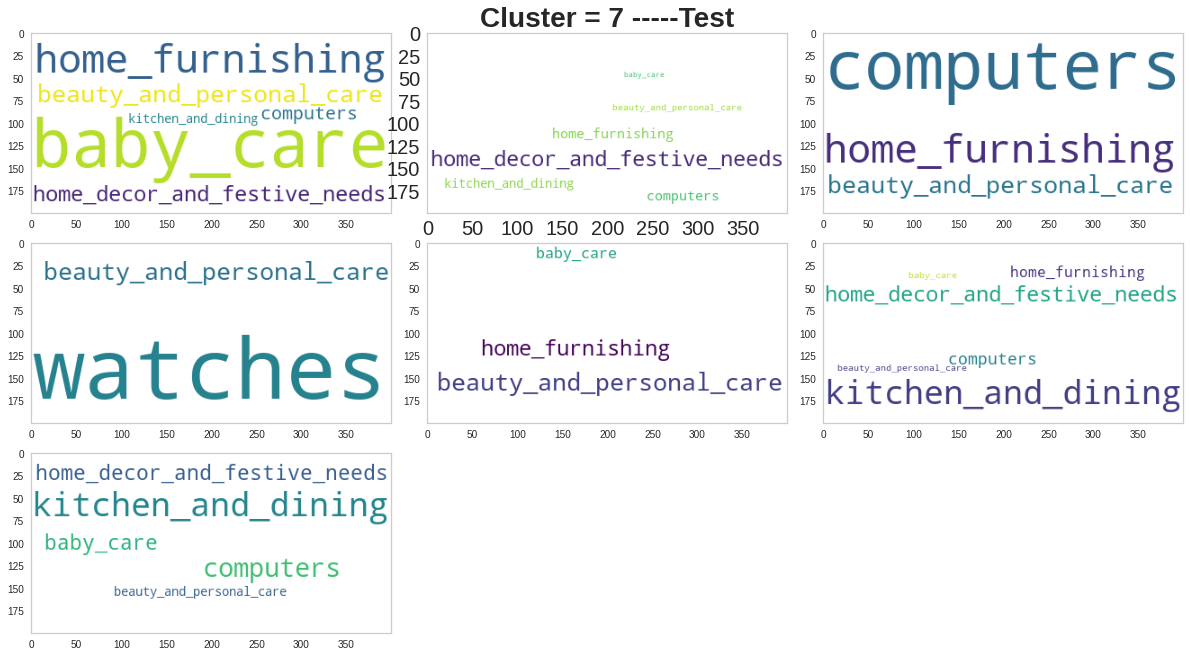

In [50]:
fig = plt.figure(figsize=(20,20))
for i in range(0,len(x_test[namecluster].unique())):
    lab1=x_test[x_test[namecluster]==i]
    wordstring=" ".join(lab1[name])
    ax = fig.add_subplot(3,3,i+1)
    wrdcloud=WordCloud(background_color='white',
                      max_font_size = 100,
                      collocations=False).generate(wordstring)
    ax.imshow(wrdcloud)
    ax.axis('on')
    ax.grid(False)
    if i==1:
        ax.set_title(namecluster +' -----Test', weight='bold', size=dss+6)
                
        plt.xticks(fontsize=dss-2)
        plt.yticks(fontsize=dss-2)

fig.subplots_adjust(left=0.1,bottom=.6, right=0.9, top=1.1, wspace=0.1, hspace=-0.3)


plt.savefig("word_2D.jpeg",format='jpeg',dpi=100,bbox_inches='tight')
!mv "word_2D.jpeg" /home/yonss/AndroidStudioProjects/P6_Presentation/Images

In [51]:
ARI_CAT_KMeans=adjusted_rand_score(x_train[name2],x_train[namecluster])

accuracy = accuracy_score(x_train[name2],x_train[namecluster])
precision= precision_score(x_train[name2],x_train[namecluster], average='weighted')

algo_Performance={"Jeu de données": "Train",'ARI':ARI_CAT_KMeans,'accuracy':accuracy ,'precision':precision}
PerformanceK = pd.DataFrame( algo_Performance,
        index=[0],
    )
ARI_CAT_KMeans=adjusted_rand_score(x_test[name2],x_test[namecluster])

accuracy = accuracy_score(x_test[name2],x_test[namecluster])
precision= precision_score(x_test[name2],x_test[namecluster], average='weighted')

algo_Performance={"Jeu de données": "Test ",'ARI':ARI_CAT_KMeans,'accuracy':accuracy ,'precision':precision}
PerformanceT = pd.DataFrame( algo_Performance,
        index=[1],)
    
df_score=PerformanceK.append(PerformanceT, ignore_index=True)
df_score

Jeu de données   ARI  accuracy  precision
0          Train  0.33      0.08       0.08
1          Test   0.35      0.09       0.10

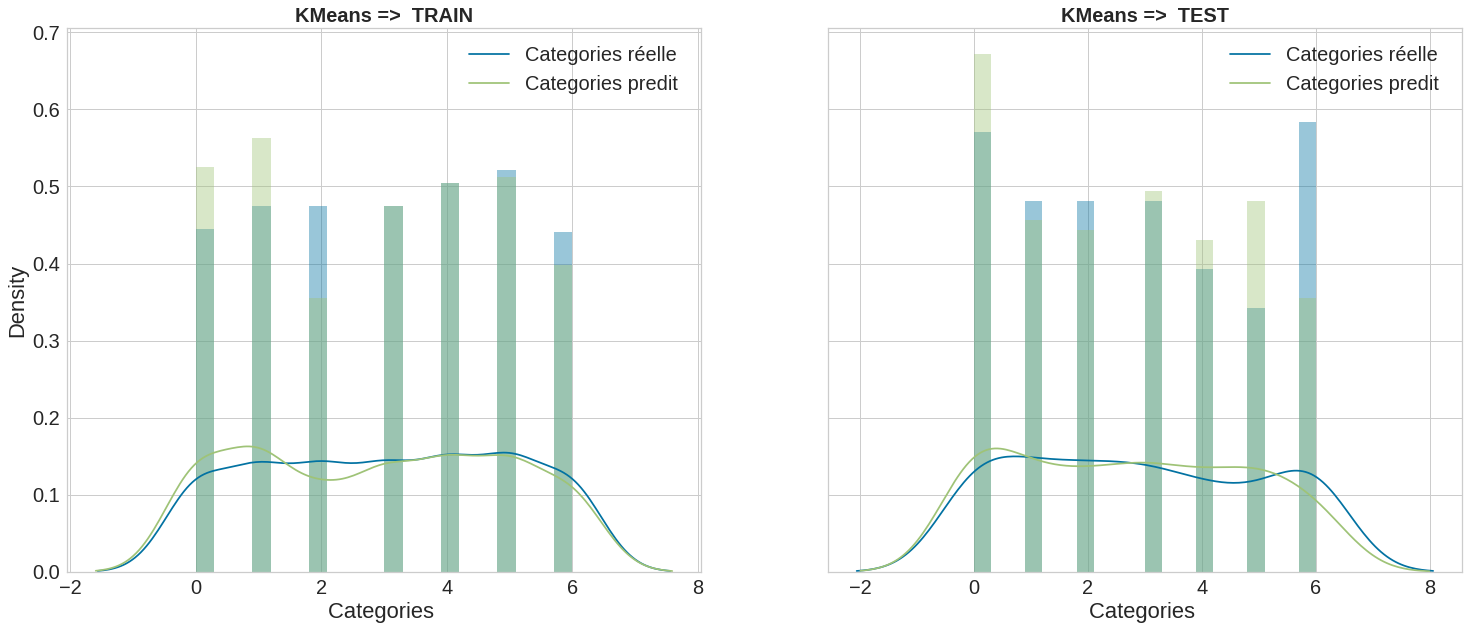

In [52]:
tnx=0
names=["Density_kmeans.jpeg"]

def distplot_dense(X,name2,namecluster,nclusters_cv,dss,ax):
    sns.distplot(X[name2], bins=20, rug=False,ax=ax)
    ax.set_title('KMeans => '+ str(nclusters_cv) , weight='bold', size=dss-2)
    sns.distplot(X[namecluster], bins=20, rug=False,ax=ax)
    ax.legend(['Categories réelle', 'Categories predit '], fontsize=dss-2)
    ax.set_ylabel('Density',  size=dss)
    ax.set_xlabel('Categories ',  size=dss)
    ax.tick_params(axis='both', labelsize=20)
    
f, (ax1,ax2) = plt.subplots(1,2, figsize=(25,10),sharey=True)
distplot_dense(x_train,name2,namecluster,' TRAIN',dss,ax1)
distplot_dense(x_test,name2,namecluster,' TEST',dss,ax2)

figure_name=names[tnx]
        
plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

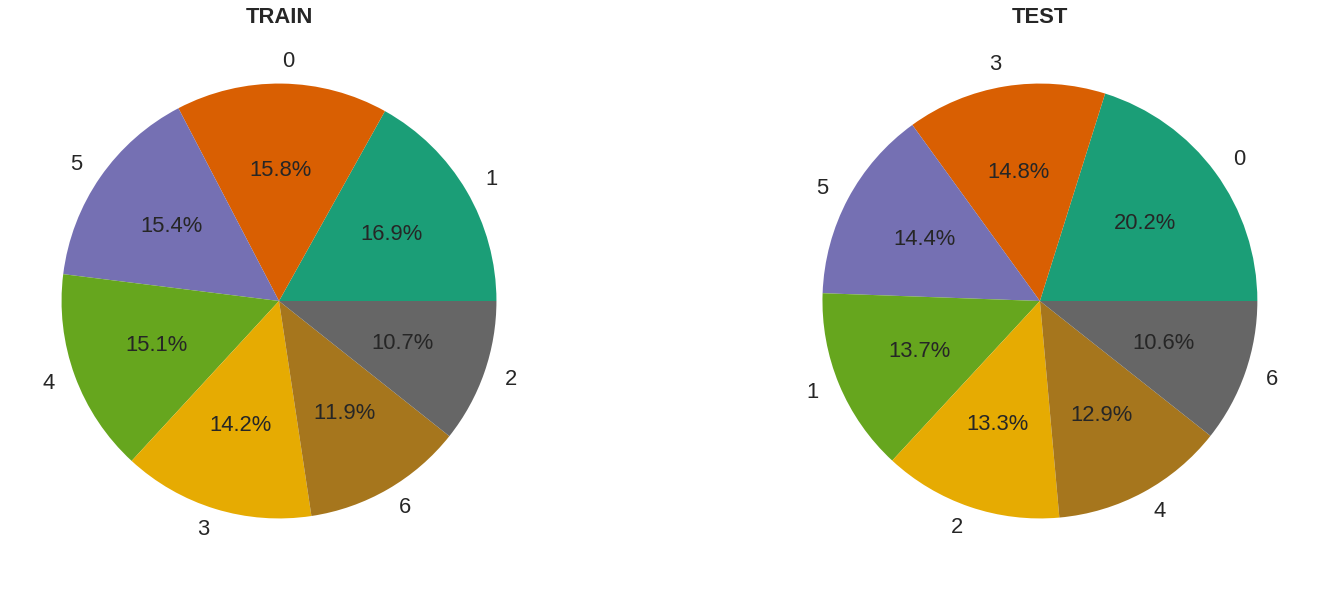

In [53]:
def pie_data(x_train,name2,namecluster,nclusters_cv,dss,ax):
    
    data_plot_0 = x_train.groupby(namecluster).agg(Clusters =(namecluster,'count'))
    data_plot_0=data_plot_0.sort_values(by='Clusters', ascending=False)
    data_plot_0.plot(kind='pie', x=name2, y='Clusters', title = '', 
    cmap='Dark2', autopct="%.1f%%", legend=False,ax=ax,fontsize=dss).set_title(nclusters_cv,fontsize=dss, weight='bold');

    ax.set_ylabel('', weight='bold', size=dss-2)
    ax.set_xlabel(' ', weight='bold', size=dss)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(25,10),sharey=True)    
pie_data(x_train,name2,namecluster,'TRAIN',dss,ax1)  
pie_data(x_test,name2,namecluster,'TEST',dss,ax2)
        
        
plt.savefig( "KMeans_pie.jpeg",format='jpeg',dpi=100,bbox_inches='tight')

!cp "KMeans_pie.jpeg" /home/yonss/AndroidStudioProjects/P6_Presentation/Images
!mv "KMeans_pie.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6

In [54]:
cmf_train= confusion_matrix(x_train[name2], x_train[namecluster])
cmf_test = confusion_matrix(x_test[name2], x_test[namecluster])

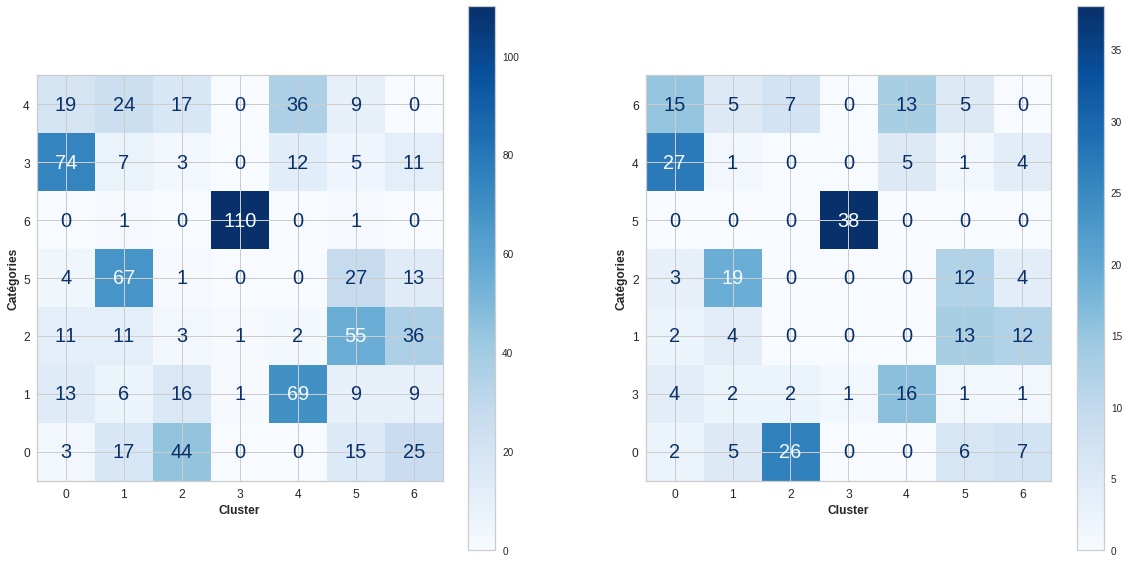

In [55]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
def matrix_conf(cmf,x_train,name2,namecluster,nclusters_cv,dss,ax):
    dss=12
    cm_display = ConfusionMatrixDisplay(cmf).plot(ax=ax,cmap=plt.cm.Blues)
    ax.set_ylabel("Catégories", weight='bold', size=dss)
    ax.set_xlabel('Cluster', weight='bold', size=dss)
    ax.set_yticklabels(x_train[name2].unique(), size=dss)
    
    ax.tick_params(axis='both', labelsize=dss)
    
matrix_conf(cmf_train,x_train,name2,namecluster,nclusters_cv,dss,ax1)
matrix_conf(cmf_test,x_test,name2,namecluster,nclusters_cv,dss,ax2) 
    